# **Compute Sentiment Using 4 SyuzhetR and 7 SentimentR Models**

* https://www.youtube.com/watch?v=U3ByGh8RmSc

* https://github.com/ttimbers/intro-to-reticulate

[Use R on Google Colab!](https://colab.research.google.com/notebook#create=true&language=r)

# **[STEP 1] Configuration and Setup**

## Configure Jupyter Notebook

In [ ]:
# Ignore warnings

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Configure Jupyter

# Enable multiple outputs from one code cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
from IPython.display import Image
from ipywidgets import widgets, interactive

## [INPUT] Connect Google gDrive to this Jupyter Notebook

In [ ]:
# [INPUT REQUIRED]: Authorize access to Google gDrive

# Connect this Notebook to your permanent Google Drive
#   so all generated output is saved to permanent storage there

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("Attempting to attach your Google gDrive to this Colab Jupyter Notebook")
  drive.mount('/gdrive')
else:
  print("Your Google gDrive is attached to this Colab Jupyter Notebook")

Attempting to attach your Google gDrive to this Colab Jupyter Notebook
Mounted at /gdrive


In [ ]:
# [CUSTOMIZE]: Change the text after the Unix '%cd ' command below (change directory)
#              to math the full path to your gDrive subdirectory which should be the 
#              root directory cloned from the SentimentArcs github repo.

# NOTE: Make sure this subdirectory already exists and there are 
#       no typos, spaces or illegals characters (e.g. periods) in the full path after %cd

# NOTE: In Python all strings must begin with an upper or lowercase letter, and only
#         letter, number and underscores ('_') characters should appear afterwards.
#         Make sure your full path after %cd obeys this constraint or errors may appear.



# Step #1: Get full path to SentimentArcs subdir on gDrive
# =======
#@markdown **Accept default path on gDrive or Enter new one:**

Path_to_SentimentArcs = "/gdrive/MyDrive/cdh/sentiment_arcs/" #@param ["/gdrive/MyDrive/sentiment_arcs/"] {allow-input: true}

#@markdown (e.g. /gdrive/MyDrive/research/sentiment_arcs/)



# Step #2: Move to Parent directory of Sentiment_Arcs
# =======
parentdir_sentiment_arcs = '/'.join(Path_to_SentimentArcs.split('/')[:-2])
print(f'subdir_parent: {parentdir_sentiment_arcs}')
%cd $parentdir_sentiment_arcs


# Step #3: If project sentiment_arcs subdir does not exist, 
#          clone it from github
# =======
import os

if not os.path.isdir('sentiment_arcs'):
  # NOTE: This will not work until SentimentArcs becomes an open sourced PUBLIC repo
  # !git clone https://github.com/jon-chun/sentiment_arcs.git

  # Test on open access github repo
  !git clone https://github.com/jon-chun/nabokov_palefire.git


# Step #4: Change into sentiment_arcs subdir
# =======
%cd ./sentiment_arcs
# Test on open acess github repo
# %cd ./nabokov_palefire

# Step #5: Confirm contents of sentiment_arcs subdir
# =======
!ls


subdir_parent: /gdrive/MyDrive/cdh
/gdrive/MyDrive/cdh
/gdrive/MyDrive/cdh/sentiment_arcs
config		  models__info.yaml  sentiment_clean  text_raw
fastText-0.9.2	  notebooks	     sentiment_raw    v0.9.2.zip
get_sentimentr.R  plots		     text_clean


In [ ]:
# [VERIFY]: Ensure that all the manually preprocessed novel are in plain text
#   files and file names are formatted correctly

# %cd ../sentiment_arcs
!pwd
!ls ./text_raw

/gdrive/MyDrive/cdh/sentiment_arcs
finance_text_new_raw  novels_text_new_raw  social_text_new_raw
finance_text_ref_raw  novels_text_ref_raw  social_text_ref_raw


## Define Directory Tree Structure

In [ ]:
#@markdown **Sentiment Arcs Directory Structure** \
#@markdown \
#@markdown **1. Input Directories:** \
#@markdown (a) Raw textfiles in subdir: ./text_raw/(text_type)/  \
#@markdown (b) Cleaned textfiles in subdir: ./text_clean/(text_type)/ \
#@markdown \
#@markdown **2. Output Directories** \
#@markdown (1) Raw Sentiment time series datafiles and plots in subdir: ./sentiment_raw/(text_type) \
#@markdown (2) Cleaned Sentiment time series datafiles and plots in subdir: ./sentiment_clean/(text_type) \
#@markdown \
#@markdown **Which type of texts are you analyzing?** \

Text_Type = "novels" #@param ["novels", "social_media", "finance"]

Corpus = "new_texts" #@param ["reference_corpora", "new_texts"]

#@markdown Please check that the required textfiles and datafiles exist in the correct subdirectories before continuing.


In [ ]:
# Create Directory CONSTANTS based On Document Type

if Corpus == "new_texts":
  Corpus_Type = "new"
else:
  Corpus_Type = "ref"

SUBDIR_TEXT_RAW = f"./text_raw/{Text_Type}_text_{Corpus_Type}_raw/"
SUBDIR_TEXT_CLEAN = f"./text_clean/{Text_Type}_text_{Corpus_Type}_clean/"
SUBDIR_SENTIMENT_RAW = f"./sentiment_raw/{Text_Type}_sentiment_{Corpus_Type}_raw/"
SUBDIR_SENTIMENT_CLEAN = f"./sentiment_clean/{Text_Type}_sentiment_{Corpus_Type}_clean/"
SUBDIR_PLOTS = f"./plots/{Text_Type}_plots/"

# Verify Directory Structure

print('Verify the Directory Structure:\n')
print('-------------------------------\n')

print(f'           [Corpus Type]: {Text_Type}\n')
print(f'       [SUBDIR_TEXT_RAW]: {SUBDIR_TEXT_RAW}\n')
print(f'     [SUBDIR_TEXT_CLEAN]: {SUBDIR_TEXT_CLEAN}\n')
print(f'  [SUBDIR_SENTIMENT_RAW]: {SUBDIR_SENTIMENT_RAW}\n')
print(f'[SUBDIR_SENTIMENT_CLEAN]: {SUBDIR_SENTIMENT_CLEAN}\n')
print(f'          [SUBDIR_PLOTS]: {SUBDIR_PLOTS}\n')

Verify the Directory Structure:

-------------------------------

           [Corpus Type]: novels

       [SUBDIR_TEXT_RAW]: ./text_raw/novels_text_new_raw/

     [SUBDIR_TEXT_CLEAN]: ./text_clean/novels_text_new_clean/

  [SUBDIR_SENTIMENT_RAW]: ./sentiment_raw/novels_sentiment_new_raw/

[SUBDIR_SENTIMENT_CLEAN]: ./sentiment_clean/novels_sentiment_new_clean/

          [SUBDIR_PLOTS]: ./plots/novels_plots/



### Read YAML Configuration for Corpus and Models 

In [ ]:
!pip install pyyaml
import yaml

In [ ]:
# Read SentimentArcs YAML Config Files for Different Corpora Types(3) and Text Files Details

# Read SentimentArcs YAML Config Files on Models

# Model in SentimentArcs Ensemble
with open("./config/models_ref_info.yaml", "r") as stream:
  try:
    models_titles_dt = yaml.safe_load(stream)
  except yaml.YAMLError as exc:
    print(exc)

if Text_Type == 'novels':

  # Novel Text Files
  if Corpus == 'new_texts':
    # Corpus of New Novels
    with open("./config/novels_new_info.yaml", "r") as stream:
      try:
        corpus_titles_dt = yaml.safe_load(stream)
      except yaml.YAMLError as exc:
        print(exc)
  else:
    # Corpus of Reference Novels
    with open("./config/novels_ref_info.yaml", "r") as stream:
      try:
        corpus_titles_dt = yaml.safe_load(stream)
      except yaml.YAMLError as exc:
        print(exc)    

elif Text_Type == 'finance':

  # Finance Text Files
  if Corpus == 'new_texts':
    # Corpus of New Finance Texts
    with open("./config/finance_new_info.yaml", "r") as stream:
      try:
        corpus_titles_dt = yaml.safe_load(stream)
      except yaml.YAMLError as exc:
        print(exc)
  else:
    # Corpus of Reference Finance Texts
    with open("./config/finance_ref_info.yaml", "r") as stream:
      try:
        corpus_titles_dt = yaml.safe_load(stream)
      except yaml.YAMLError as exc:
        print(exc)

elif Text_Type == 'social_media':

  # Social Media Text Files
  if Corpus == 'new_texts':
    # Corpus of New Social Media Texts
    with open("./config/social_new_info.yaml", "r") as stream:
      try:
        corpus_titles_dt = yaml.safe_load(stream)
      except yaml.YAMLError as exc:
        print(exc)
  else:
    # Corpus of Reference Social Media Texts
    with open("./config/social_ref_info.yaml", "r") as stream:
      try:
        corpus_titles_dt = yaml.safe_load(stream)
      except yaml.YAMLError as exc:
        print(exc)

else:
  
  print(f"ERROR: Illegal Text_Type: {Text_Type}\n")

print(f'Corpus Titles Dictionary =')
corpus_titles_dt.keys()

print(f'\n\nThe Corpus Titles contains [{len(corpus_titles_dt.keys())} {Text_Type}] textfiles ')
print(f'\nFirst Text in Corpus:')
print(corpus_titles_dt[next(iter(corpus_titles_dt))])

Corpus Titles Dictionary =


dict_keys(['scollins_thehungergames1', 'cmieville_thecityandthecity'])



The Corpus Titles contains [2 novels] textfiles 

First Text in Corpus:
['The Hunger Games 1 by Suzanne Collins ', 2008, 0]


In [ ]:
import json

In [ ]:
# Verify the Corpora Text Titles

print(json.dumps(corpus_titles_dt, indent=2))

{
  "scollins_thehungergames1": [
    "The Hunger Games 1 by Suzanne Collins ",
    2008,
    0
  ],
  "cmieville_thecityandthecity": [
    "The City and The City by China Mieville",
    2009,
    0
  ]
}


## Define Globals

In [ ]:
# TODO

## Install Libraries: R

In [ ]:
# !pip install rpy2

In [ ]:
# !pip install -U rpy2

In [ ]:
# Load Jupyter rpy2 Extension  
#   enables the %%R magic commands

%load_ext rpy2.ipython

In [ ]:
# %reload_ext rpy2.ipython

In [ ]:
%%time 
%%capture 
%%R

# Install Syuzhet.R, Sentiment.R and Utility Libraries

# NOTE: 1m12s 
#       1m05s

install.packages(c('syuzhet', 'sentimentr', 'tidyverse', 'lexicon'))

library(syuzhet)
library(sentimentr)
library(tidyverse)
library(lexicon)

CPU times: user 3.06 s, sys: 265 ms, total: 3.33 s
Wall time: 1min 14s


In [ ]:
# %reload_ext rpy2.ipython

In [ ]:
# Load Python libraries to exchange data with R Program Space and read R Datafiles

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr

In [ ]:
%%R

# Verify R in Kernel Version

R.version.string

[1] "R version 4.1.2 (2021-11-01)"


In [ ]:
%%R

# Verify R Kernel Session Info

sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] lexicon_1.2.1    forcats_0.5.1    stringr_1.4.0    dplyr_1.0.8     
 [5] purrr_0.3.4      readr_2.1.2      tidyr_1.2.0      tibble_3.1.6    
 [9] ggplot2_3.3.5    tidyverse_1.3.1  sentimentr_2.9.0 syuzhet_1.0.6   

loaded via a namespace (and not atta

In [ ]:
%%R

# Verfiy R Kernel Environment

# Sys.getenv


NULL


## Install Libraries: Python

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
from glob import glob
import copy
# import json # Installed above in YAML Configuration Section

## Setup Matplotlib Style

* https://matplotlib.org/stable/tutorials/introductory/customizing.html

In [ ]:
from cycler import cycler

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']   
linestyles = ['-', '--', ':', '-.','-', '--', ':', '-.','-', '--']

cycle = plt.cycler("color", colors) + plt.cycler("linestyle", linestyles)

# View previous matplotlib configuration
print('\n Old Matplotlib Configurtion Settings:\n')
# plt.rc.show
print('\n\n')

# Update and view new matplotlib configuration
print('\n New Matplotlib Configurtion Settings:\n')
myparams = {'axes.prop_cycle': cycle}
plt.rcParams.update(myparams)

plt.rcParams["axes.titlesize"] = 16
plt.rcParams['figure.figsize'] = 20,10
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.labelsize"] = 12



 Old Matplotlib Configurtion Settings:





 New Matplotlib Configurtion Settings:



In [ ]:
# Set matplotlib plot figure.figsize

new_plt_size = plt.rcParams["figure.figsize"]=(20,10)

print(" New figure size: ",new_plt_size)

 New figure size:  (20, 10)


## Setup Seaborn Style

In [ ]:
# View previous seaborn configuration
print('\n Old Seaborn Configurtion Settings:\n')
sns.axes_style()
print('\n\n')

# Update and View new seaborn configuration
print('\n New Seaborn Configurtion Settings:\n')
# sns.set_style('white')
sns.set_context('paper')
sns.set_style('white')
sns.set_palette('tab10')

# Change defaults
# sns.set(style='white', context='talk', palette='tab10')


 Old Seaborn Configurtion Settings:



{'axes.axisbelow': 'line',
 'axes.edgecolor': 'black',
 'axes.facecolor': 'white',
 'axes.grid': False,
 'axes.labelcolor': 'black',
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': (1, 1, 1, 0),
 'font.family': ['sans-serif'],
 'font.sans-serif': ['DejaVu Sans',
  'Bitstream Vera Sans',
  'Computer Modern Sans Serif',
  'Lucida Grande',
  'Verdana',
  'Geneva',
  'Lucid',
  'Arial',
  'Helvetica',
  'Avant Garde',
  'sans-serif'],
 'grid.color': '#b0b0b0',
 'grid.linestyle': '-',
 'image.cmap': 'viridis',
 'lines.solid_capstyle': 'projecting',
 'patch.edgecolor': 'black',
 'patch.force_edgecolor': False,
 'text.color': 'black',
 'xtick.bottom': True,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False}





 New Seaborn Configurtion Settings:



In [ ]:
# Seaborn: Set Theme (Scale of Font)

sns.set_theme('paper')  # paper, notebook, talk, poster


# Seaborn: Set Context
# sns.set_context("notebook")



# Seaborn: Set Style

# sns.set_style('ticks') # darkgrid, whitegrid, dark, white, and ticks

In [ ]:
# Seaborn: Default Palette (Pastel?)

sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [ ]:
# Seaborn: Set to High-Contrast Palette (more Vision Impaired Friendly)

sns.set_palette('tab10')
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [ ]:
plt.style.use('seaborn-whitegrid')

## Python Utility Functions

In [ ]:
# Utility functions to read/write nested Dictionary (key=novel) of DataFrames (Cols = Model Sentiment Series) 

def write_dict_dfs(adict, out_file='sentiments.json', out_dir=SUBDIR_SENTIMENT_RAW):
  '''
  Given a Dictionary of DataFrames and optional output filename and output directory
  Write as nested json file
  '''

  # convert dataframes into dictionaries
  data_dict = {
      key: adict[key].to_dict(orient='records') 
      for key in adict.keys()
  }

  # write to disk
  out_fullpath = f'{out_dir}{out_file}'
  print(f'Saving file to: {out_fullpath}')
  with open(out_fullpath, 'w') as fp:
    json.dump(
      data_dict, 
      fp, 
      indent=4, 
      sort_keys=True
    )

  return 

def read_dict_dfs(in_file='sentiments.json', in_dir=SUBDIR_SENTIMENT_RAW):
  '''
  Given a Dictionary of DataFrames and optional output filename and output directory
  Read nested json file into Dictionary of DataFrames
  '''

  # read from disk
  in_fullpath = f'{in_dir}{in_file}'
  with open(in_fullpath, 'r') as fp:
      data_dict = json.load(fp)

  # convert dictionaries into dataframes
  all_dt = {
      key: pd.DataFrame(data_dict[key]) 
      for key in data_dict
  }

  return all_dt

# **[STEP 2] Read all Preprocessed Novels**

In [ ]:
# Verify cwd and subdir of Cleaned Corpus Texts

print('Current Working Directory:')
!pwd

print(f'\nSubdir with all Cleaned Texts of Corpus:\n  {SUBDIR_TEXT_CLEAN}')

print(f'\n\nFilenames of Cleaned Texts:\n')
!ls -1 $SUBDIR_TEXT_CLEAN

Current Working Directory:
/gdrive/MyDrive/cdh/sentiment_arcs

Subdir with all Cleaned Texts of Corpus:
  ./text_clean/novels_text_new_clean/


Filenames of Cleaned Texts:

cmieville_thecityandthecity.csv
scollins_thehungergames1.csv


In [ ]:
# Create a List (preprocessed_ls) of all preprocessed text files

try:
    preprocessed_ls = glob(f'{SUBDIR_TEXT_CLEAN}*.csv')
    preprocessed_ls = [x.split('/')[-1] for x in preprocessed_ls]
    preprocessed_ls = [x.split('.')[0] for x in preprocessed_ls]
except IndexError:
    raise RuntimeError('No csv file found')

print('\n'.join(preprocessed_ls))
print('\n')
print(f'Found {len(preprocessed_ls)} Preprocessed files in {SUBDIR_TEXT_CLEAN}')

scollins_thehungergames1
cmieville_thecityandthecity


Found 2 Preprocessed files in ./text_clean/novels_text_new_clean/


In [ ]:
# Read all preprocessed text files into master DataFrame (corpus_dt)

corpus_texts_dt = {}

for i,anovel in enumerate(preprocessed_ls):
  print(f'Processing #{i}: {anovel}...')
  afile_fullpath = f'{SUBDIR_TEXT_CLEAN}{anovel}.csv'
  print(f'               {afile_fullpath}')
  anovel_df = pd.read_csv(afile_fullpath, index_col=[0])
  corpus_texts_dt[anovel] = anovel_df

Processing #0: scollins_thehungergames1...
               ./text_clean/novels_text_new_clean/scollins_thehungergames1.csv
Processing #1: cmieville_thecityandthecity...
               ./text_clean/novels_text_new_clean/cmieville_thecityandthecity.csv


In [ ]:
# Verify the novels read into master Dictionary of DataFrames

corpus_texts_dt.keys()
print('\n')
print(f'There were {len(corpus_texts_dt)} preprocessed novels read into the Dict corpus_texts_dt')

dict_keys(['scollins_thehungergames1', 'cmieville_thecityandthecity'])



There were 2 preprocessed novels read into the Dict corpus_texts_dt


In [ ]:
# Check if there are any Null strings in the text_clean columns

for i, anovel in enumerate(list(corpus_texts_dt.keys())):
  print(f'\nNovel #{i}: {anovel}')
  nan_ct = corpus_texts_dt[anovel].text_clean.isna().sum()
  if nan_ct > 0:
    print(f'      {nan_ct} Null strings in the text_clean column')


Novel #0: scollins_thehungergames1
      24 Null strings in the text_clean column

Novel #1: cmieville_thecityandthecity


In [ ]:
# Fill in all the Null value of text_clean with placeholder 'empty_string'

for i, anovel in enumerate(list(corpus_texts_dt.keys())):
  # print(f'Novel #{i}: {anovel}')
  # Fill all text_clean == Null with 'empty_string' so sentimentr::sentiment doesn't break
  corpus_texts_dt[anovel][corpus_texts_dt[anovel].text_clean.isna()] = 'empty_string'

In [ ]:
# Verify DataFrame of first Text in Corpus Dictionary

corpus_texts_dt[next(iter(corpus_texts_dt))].head()

text_raw                                         text_clean
0                                     "THE TRIBUTES"                                        the tribute
1  When I wake up, the other side of the bed is c...   when i wake up the other side of the bed be cold
2  My fingers stretch out, seeking Prims warmth b...  my finger stretch out seek prims warmth but fi...
3  She must have had bad dreams and climbed in wi...  she must have have bad dream and climb in with...
4                                Of course, she did.                                   of course she do

# **[STEP 3] Get Sentiments with SyuzhetR (4 Models)**

## Option (a): Read Previously Computed SyuzhetR Values from Datafiles

In [ ]:
# Read in Saved SyuzhetR Datafile from subdir_sentiments/all_4syuzhetr.json

corpus_syuzhetr_dt = read_dict_dfs('all_4syuzhetr.json')
corpus_syuzhetr_dt.keys()

In [ ]:
# Verify all the Novels have 4 Syuzhet Model Values

for i, anovel in enumerate(list(corpus_syuzhetr_dt.keys())):
  print(f'Novel #{i}: {anovel}')
  corpus_syuzhetr_dt[anovel].drop(columns=['Unnamed: 0'], inplace=True)
  print(f'      df.shape: {corpus_syuzhetr_dt[anovel].shape}')

In [ ]:
# Verify DataFrame for test novel

novel_str = 'cdickens_achristmascarol'
corpus_syuzhetr_dt[novel_str].head()

## Option (b): Compute New SyuzhetR Values

In [ ]:
# Verify text_clean of sample text

corpus_texts_dt[next(iter(corpus_texts_dt))]['text_clean'].to_list()[:10]

['the tribute',
 'when i wake up the other side of the bed be cold',
 'my finger stretch out seek prims warmth but find only the rough canvas cover of the mattress',
 'she must have have bad dream and climb in with our mother',
 'of course she do',
 'this be the day of the reap',
 'i prop myself up on one elbow',
 'there be enough light in the bedroom to see them',
 'my little sister prim curl up on her side cocoon in my mother body their cheek press together',
 'in sleep my mother look young still wear but not so beat down']

In [ ]:
%%time

# Compute Sentiments from all 4 Syuzhet Models applied to all 32 Novels (4 x 32 = 128 runs)

# NOTE:  9m45s 23:30 on 20220114 Colab Pro (33 Novels)
#       28:32s 21:06 on 20220226 Colab Pro (33 Novels)
#        3m20s 19:11 on 20220217 Colab Pro (2 Novels)
#        3m05s 19:17 on 20220217 Colab Pro (2 Novels)

# base = importr('base')
syuzhet = importr('syuzhet')

# corpus_syuzhetr_dt = {}

# base.rank(0, na_last = True)
texts_titles_ls = list(corpus_texts_dt.keys())
texts_titles_ls.sort()
for i, anovel in enumerate(texts_titles_ls):
  print(f'Processing Novel #{i}: {anovel}...')
  corpus_texts_dt[anovel]['syuzhetr_syuzhet'] = syuzhet.get_sentiment(corpus_texts_dt[anovel]['text_clean'].to_list(), method='syuzhet')
  corpus_texts_dt[anovel]['syuzhetr_bing'] = syuzhet.get_sentiment(corpus_texts_dt[anovel]['text_clean'].to_list(), method='bing')
  corpus_texts_dt[anovel]['syuzhetr_afinn'] = syuzhet.get_sentiment(corpus_texts_dt[anovel]['text_clean'].to_list(), method='afinn')
  corpus_texts_dt[anovel]['syuzhetr_nrc'] = syuzhet.get_sentiment(corpus_texts_dt[anovel]['text_clean'].to_list(), method='nrc')

Processing Novel #0: cmieville_thecityandthecity...
Processing Novel #1: scollins_thehungergames1...
CPU times: user 2min 58s, sys: 944 ms, total: 2min 59s
Wall time: 3min 5s


In [ ]:
# Verify First Text in Corpus has New SyuzhetR Columns with Plausible Values

corpus_texts_dt[next(iter(corpus_texts_dt))].head()

corpus_texts_dt[next(iter(corpus_texts_dt))].info()

text_raw  ... syuzhetr_nrc
0                                     "THE TRIBUTES"  ...          1.0
1  When I wake up, the other side of the bed is c...  ...         -1.0
2  My fingers stretch out, seeking Prims warmth b...  ...          0.0
3  She must have had bad dreams and climbed in wi...  ...         -1.0
4                                Of course, she did.  ...          0.0

[5 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9021 entries, 0 to 9020
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text_raw          9021 non-null   object 
 1   text_clean        9021 non-null   object 
 2   syuzhetr_syuzhet  9021 non-null   float64
 3   syuzhetr_bing     9021 non-null   int64  
 4   syuzhetr_afinn    9021 non-null   int64  
 5   syuzhetr_nrc      9021 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 493.3+ KB


## Checkpoint: Save SyuzhetR Values

In [ ]:
# Verify in SentimentArcs Root Directory
#   and destination Subdir for Raw Sentiment Values

!pwd
print('\n')

print(f'SUBDIR_SENTIMENT_RAW: {SUBDIR_SENTIMENT_RAW}\n\n')

print('Existing Sentiment Datafiles in Destination Subdir:\n')

!ls $SUBDIR_SENTIMENT_RAW

/gdrive/MyDrive/cdh/sentiment_arcs


SUBDIR_SENTIMENT_RAW: ./sentiment_raw/novels_sentiment_new_raw/


Existing Sentiment Datafiles in Destination Subdir:



In [ ]:
# Verify Saving Corpus

print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')

print(f'\nThese Text Titles:\n')
corpus_texts_dt.keys()

Saving Text_Type: novels
     Corpus_Type: new

These Text Titles:



dict_keys(['scollins_thehungergames1', 'cmieville_thecityandthecity'])

In [ ]:
# Save sentiment values to subdir_sentiments

save_filename = f'all_{Text_Type}_{Corpus_Type}_4syuzhetr.json'

write_dict_dfs(corpus_texts_dt, out_file=save_filename, out_dir=SUBDIR_SENTIMENT_RAW)

Saving file to: ./sentiment_raw/novels_sentiment_new_raw/all_novels_new_4syuzhetr.json


In [ ]:
# Verify Dictionary was saved correctly by reading back the *.json datafile

test_dt = read_dict_dfs(in_file=save_filename, in_dir=SUBDIR_SENTIMENT_RAW)
test_dt.keys()

dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

## Plot SyuzhetR 4 Models

In [ ]:
#@markdown Select option to save plots:
Save_Raw_Plots = True #@param {type:"boolean"}

Save_Smooth_Plots = True #@param {type:"boolean"}
Resolution = "300" #@param ["100", "300"]



In [ ]:
# Get Col Names for all 4 SyuzhetR Models

cols_all_ls = corpus_texts_dt[next(iter(corpus_texts_dt))].columns

cols_syuzhetr_ls = [x for x in cols_all_ls if 'syuzhetr_' in x]
cols_syuzhetr_ls

['syuzhetr_syuzhet', 'syuzhetr_bing', 'syuzhetr_afinn', 'syuzhetr_nrc']

In [ ]:
corpus_texts_dt[next(iter(corpus_texts_dt))].iloc[0]

text_raw            "THE TRIBUTES"
text_clean             the tribute
syuzhetr_syuzhet               0.6
syuzhetr_bing                    0
syuzhetr_afinn                   2
syuzhetr_nrc                   1.0
Name: 0, dtype: object

In [ ]:
print(f'Saving Plots to Subdir: {SUBDIR_PLOTS}')

Saving Plots to Subdir: ./plots/novels_plots/


Novel #0: The Hunger Games 1 by Suzanne Collins 
Saving to: ./plots/novels_plots/plot_syuzhetr_raw_scollins_thehungergames1_dpi300.png


Saving to: ./plots/novels_plots/plot_syuzhetr_smooth10sma_scollins_thehungergames1_dpi300.png
Novel #1: The City and The City by China Mieville
Saving to: ./plots/novels_plots/plot_syuzhetr_raw_cmieville_thecityandthecity_dpi300.png


Saving to: ./plots/novels_plots/plot_syuzhetr_smooth10sma_cmieville_thecityandthecity_dpi300.png


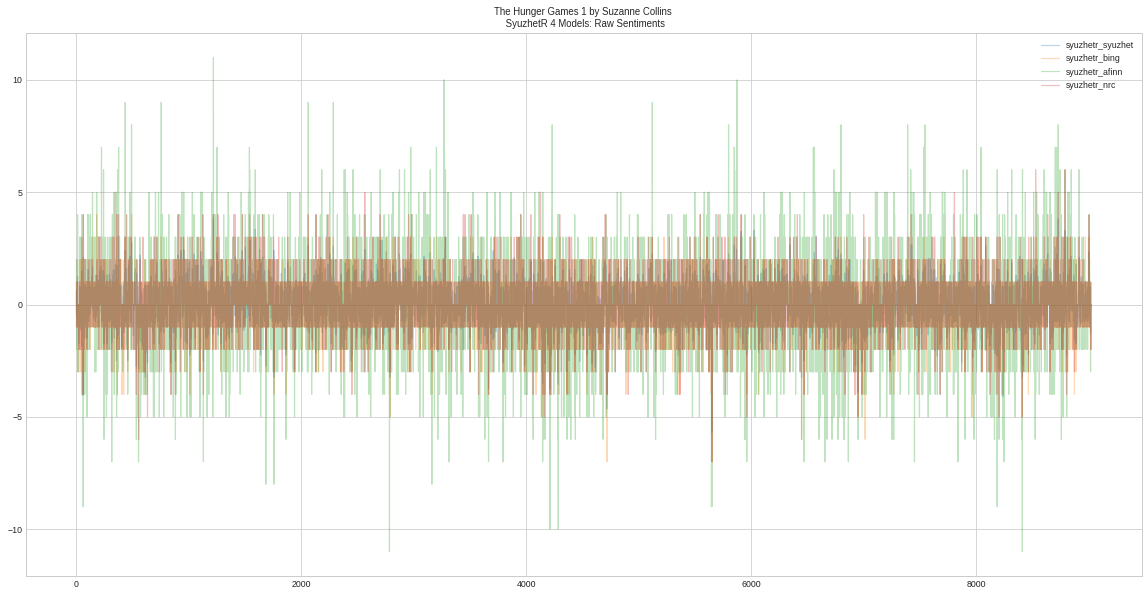

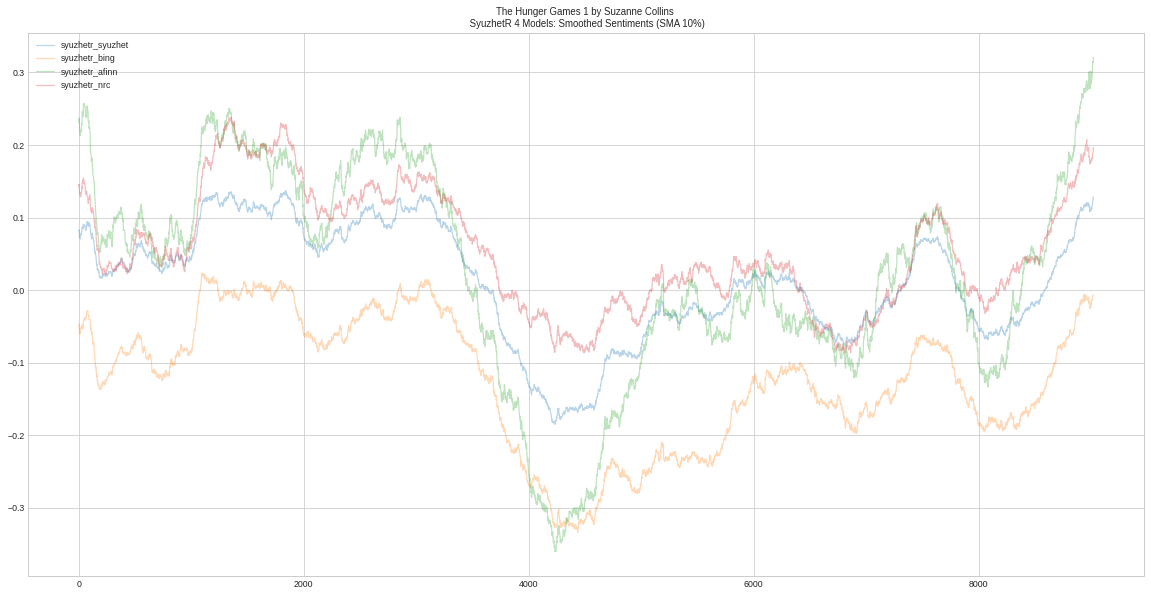

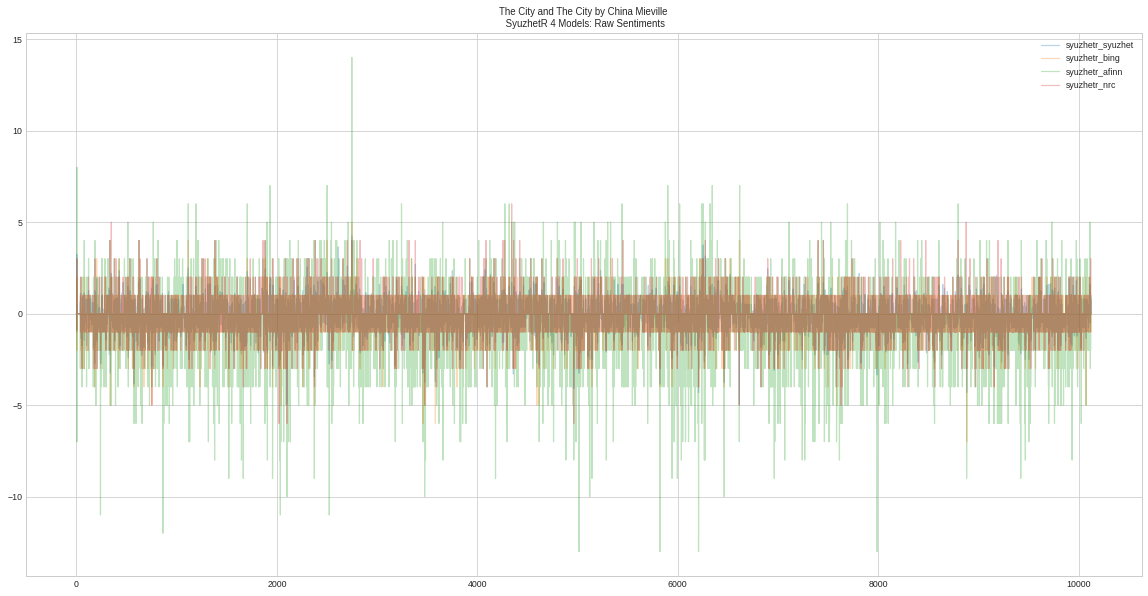

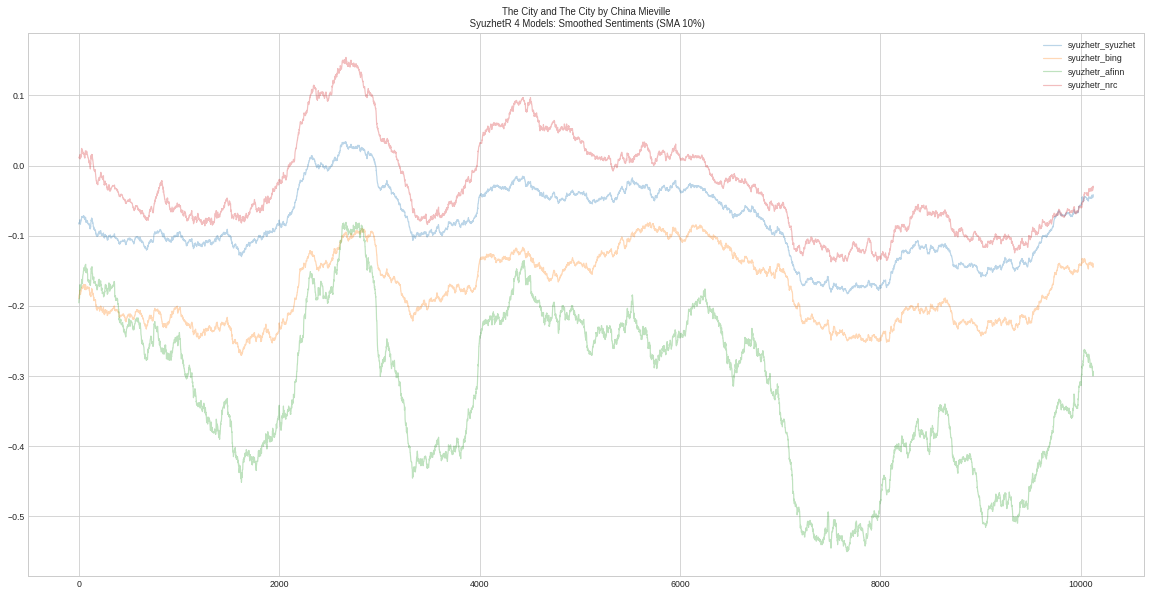

In [ ]:
# Verify 4 SyuzhetR Models with Plots

for i, anovel in enumerate(list(corpus_texts_dt.keys())):

  print(f'Novel #{i}: {corpus_titles_dt[anovel][0]}')

  # Raw Sentiments 
  fig = corpus_texts_dt[anovel][cols_syuzhetr_ls].plot(title=f'{corpus_titles_dt[anovel][0]}\n SyuzhetR 4 Models: Raw Sentiments', alpha=0.3)
  # plt.show();

  if Save_Raw_Plots:
    save_filename = f'{SUBDIR_PLOTS}plot_syuzhetr_raw_{anovel}_dpi{Resolution}.png'
    print(f'\n\nSaving to: {save_filename}')
    plt.savefig(save_filename, dpi=int(Resolution))

  
  # Smoothed Sentiments (SMA 10%)
  # novel_sample = 'cdickens_achristmascarol'
  win_10per = int(corpus_texts_dt[anovel].shape[0] * 0.1)
  corpus_texts_dt[anovel][cols_syuzhetr_ls].rolling(win_10per, center=True, min_periods=0).mean().plot(title=f'{corpus_titles_dt[anovel][0]}\n SyuzhetR 4 Models: Smoothed Sentiments (SMA 10%)', alpha=0.3)
  # plt.show();

  if Save_Smooth_Plots:
    save_filename = f'{SUBDIR_PLOTS}plot_syuzhetr_smooth10sma_{anovel}_dpi{Resolution}.png'
    print(f'\n\nSaving to: {save_filename}')
    plt.savefig(save_filename, dpi=int(Resolution))


# **[STEP 4] Get Sentiments with SentimentR (7 Models)**

## Option (a): Read Previous Computed SentimentR Values from DataFile

In [ ]:
# Read in Saved SyuzhetR Datafile from subdir_sentiments/all_4syuzhetr.json

corpus_sentimentr_dt = read_dict_dfs('all_7sentimentr.json')
corpus_sentimentr_dt.keys()

In [ ]:
# Verify all the Novels have 4 Syuzhet Model Values

for i, anovel in enumerate(list(corpus_sentimentr_dt.keys())):
  print(f'Novel #{i}: {anovel}')
  corpus_sentimentr_dt[anovel].drop(columns=['Unnamed: 0'], inplace=True)
  print(f'      df.shape: {corpus_sentimentr_dt[anovel].shape}')

In [ ]:
# Verify DataFrame for test novel

novel_str = 'cdickens_achristmascarol'
corpus_sentimentr_dt[novel_str].head()

## Option (b): Compute New SentimentR Values

Call function in external get_sentimentr.R from within Python Loop

* https://medium.com/analytics-vidhya/calling-r-from-python-magic-of-rpy2-d8cbbf991571

* https://rpy2.github.io/doc/v3.0.x/html/generated_rst/pandas.html

In [ ]:
%%file get_sentimentr.R

library(sentimentr)
library(lexicon)

get_sentimentr_values <- function(s_v) {
  
  print('Processing sentimentr_jockersrinker')
  sentimentr_jockersrinker <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_jockers_rinker, 
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('Processing sentimentr_jockers')
  sentimentr_jockers <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_jockers, 
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('Processing sentimentr_huliu')
  sentimentr_huliu <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_huliu, 
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('Processing sentimentr_nrc')
  sentimentr_nrc <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_nrc, 
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('Processing sentimentr_senticnet')
  sentimentr_senticnet <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_senticnet, 
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('Processing sentimentr_sentiword')
  sentimentr_sentiword <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_sentiword, 
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('Processing sentimentr_loughran_mcdonald')
  sentimentr_loughran_mcdonald <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_loughran_mcdonald, 
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('Processing sentimentr_socal_google')
  sentimentr_socal_google <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_socal_google, 
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  anovel_sentimentr_df <- data.frame('text_clean' = s_v,
                                'sentimentr_jockersrinker' = sentimentr_jockersrinker$sentiment,
                                'sentimentr_jockers' = sentimentr_jockers$sentiment,
                                'sentimentr_huliu' = sentimentr_huliu$sentiment,
                                'sentimentr_nrc' = sentimentr_nrc$sentiment,
                                'sentimentr_senticnet' = sentimentr_senticnet$sentiment,
                                'sentimentr_sentiword' = sentimentr_sentiword$sentiment,
                                'sentimentr_loughran_mcdonald' = sentimentr_loughran_mcdonald$sentiment,
                                'sentimentr_socal_google' = sentimentr_socal_google$sentiment
                                )
  return(anovel_sentimentr_df)

}

Overwriting get_sentimentr.R


In [ ]:
# Verify the *.R file above was written correctly

!cat get_sentimentr.R


library(sentimentr)
library(lexicon)

get_sentimentr_values <- function(s_v) {
  
  print('Processing sentimentr_jockersrinker')
  sentimentr_jockersrinker <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_jockers_rinker, 
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('Processing sentimentr_jockers')
  sentimentr_jockers <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_jockers, 
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
                                        adversative.weight=0.25, neutral.nonverb.like = FALSE, missing_value = 0)

  print('Processing sentimentr_huliu')
  sentimentr_huliu <- sentiment(s_v, polarity_dt=lexicon::hash_sentiment_huliu, 
                                        hypen="", amplifier.weight=0.8, n.before=5, n.after=2,
           

In [ ]:
# Setup python robject with external library::function()
# https://rpy2.github.io/doc/v3.0.x/html/generated_rst/pandas.html

# import rpy2.robjects as robjects

# Defining the R script and loading the instance in Python
# from rpy2.robjects import pandas2ri 
r = robjects.r

# Loading the function we have defined in R.
r['source']('get_sentimentr.R')

# Reading and processing data
get_sentimentr_function_r = robjects.globalenv['get_sentimentr_values']

<rpy2.robjects.vectors.ListVector object at 0x7f4aa1509230> [RTYPES.VECSXP]
R classes: ('list',)
[SexpClosure, BoolSexpVector]
  value: <class 'rpy2.rinterface.SexpClosure'>
  <rpy2.rinterface.SexpClosure object at 0x7f4aa124ed20> [RTYPES.CLOSXP]
  visible: <class 'rpy2.rinterface.BoolSexpVector'>
  <rpy2.rinterface.BoolSexpVector object at 0x7f4aa1509320> [RTYPES.LGLSXP]

In [ ]:
# Test

# Convert Python List of Strings to a R vector of characters
test_ls = corpus_texts_dt[next(iter(corpus_texts_dt))]['text_clean'].to_list()
s_v = robjects.StrVector(test_ls)
type(s_v)

get_sentimentr_function_r(s_v)

rpy2.robjects.vectors.StrVector

[1] "Processing sentimentr_jockersrinker"
[1] "Processing sentimentr_jockers"
[1] "Processing sentimentr_huliu"
[1] "Processing sentimentr_nrc"
[1] "Processing sentimentr_senticnet"
[1] "Processing sentimentr_sentiword"
[1] "Processing sentimentr_loughran_mcdonald"
[1] "Processing sentimentr_socal_google"


<rpy2.robjects.vectors.DataFrame object at 0x7f4aa165eeb0> [RTYPES.VECSXP]
R classes: ('data.frame',)
[StrSexpVe..., FloatSexp..., FloatSexp..., FloatSexp..., ..., FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp...]
  text_clean: <class 'rpy2.rinterface_lib.sexp.StrSexpVector'>
  <rpy2.rinterface_lib.sexp.StrSexpVector object at 0x7f4aa165e1e0> [RTYPES.STRSXP]
  sentimentr_jockersrinker: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7f4aa166b500> [RTYPES.REALSXP]
  sentimentr_jockers: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7f4aa166bf00> [RTYPES.REALSXP]
  sentimentr_huliu: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7f4aa166bbe0> [RTYPES.REALSXP]
  sentimentr_nrc: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7f4aa166bc30> [RTYPES.REALSXP]
  sentimentr_senticnet: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7f4aa166be10> [RTYPES.REALSXP]
  sentimentr_sentiword: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7f4aa166bc30> [RTYPES.REALSXP]
  sentimentr_loughran_mcdonald: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7f4aa1478190> [RTYPES.REALSXP]
  sentimentr_socal_google: <class 'rpy2.rinterface.FloatSexpVector'>
  <rpy2.rinterface.FloatSexpVector object at 0x7f4aa166bc30> [RTYPES.REALSXP]

In [ ]:
corpus_texts_dt.keys()

dict_keys(['scollins_thehungergames1', 'cmieville_thecityandthecity'])

In [ ]:
text_clean_ct = corpus_texts_dt[next(iter(corpus_texts_dt))].text_clean.isna().sum()
text_clean_ct
# len(text_clean_ls.isnull())

0

**[RE-EXECUTE] May have to re-execute following code cell several times**

In [ ]:
%whos dict

Variable           Type    Data/Info
------------------------------------
corpus_texts_dt    dict    n=2
corpus_titles_dt   dict    n=2
models_titles_dt   dict    n=34
myparams           dict    n=1
test_dt            dict    n=2


In [ ]:
corpus_texts_dt.keys()

dict_keys(['scollins_thehungergames1', 'cmieville_thecityandthecity'])

In [ ]:
%%time

# NOTE: 8m19s 13 Novels 
#      16m39s 19 Novels
#     -----------------
#      24m58s 32 Novels
#       5m00s  @19:44 on 20220227 Colab Pro (2 Novels)

# Call external get_sentimentr::get_sentimentr_values with Python loop over all novels

# novels_sentimentr_dt = {}

anovel_df = pd.DataFrame()

novels_titles_ls = list(corpus_texts_dt.keys())
novels_titles_ls.sort()
# for i, anovel in enumerate(novels_titles_ls[:19]):
for i, anovel in enumerate(novels_titles_ls):  
  print(f'\nProcessing Novel #{i}: {anovel}')
  
  # Delete contents of anovel_df DataFrame
  anovel_df = anovel_df[0:0]

  print(f'     {corpus_texts_dt[anovel].shape}')
  # Get text_clean as list of strings
  text_clean_ls = corpus_texts_dt[anovel]['text_clean'].to_list()

  # Convert Python List of Strings to a R vector of characters
  # https://rpy2.github.io/doc/v3.0.x/html/generated_rst/pandas.html
  s_v = robjects.StrVector(text_clean_ls)
  anovel_df_r = get_sentimentr_function_r(s_v)

  # Convert rpy2.robjects.vectors.DataFrame to pandas.core.frame.DataFrame
  # https://stackoverflow.com/questions/20630121/pandas-how-to-convert-r-dataframe-back-to-pandas 
  print(f'type(anovel_df_r): {type(anovel_df_r)}')
  anovel_df = pd.DataFrame.from_dict({ key : np.asarray(anovel_df_r.rx2(key)) for key in anovel_df_r.names })
  print(f'type(anovel_df): {type(anovel_df)}')

  # Save Results
  # novels_dt[anovel] = anovel_df.copy(deep=True)

  # This works for Novels New Corpus Texts
  corpus_texts_dt[anovel]['sentimentr_jockersrinker'] = anovel_df['sentimentr_jockersrinker']
  corpus_texts_dt[anovel]['sentimentr_jockers'] = anovel_df['sentimentr_jockers']
  corpus_texts_dt[anovel]['sentimentr_huliu'] = anovel_df['sentimentr_huliu']
  corpus_texts_dt[anovel]['sentimentr_nrc'] = anovel_df['sentimentr_nrc']
  corpus_texts_dt[anovel]['sentimentr_senticnet'] = anovel_df['sentimentr_senticnet']
  corpus_texts_dt[anovel]['sentimentr_sentiword'] = anovel_df['sentimentr_sentiword']
  corpus_texts_dt[anovel]['sentimentr_loughran_mcdonald'] = anovel_df['sentimentr_loughran_mcdonald']
  corpus_texts_dt[anovel]['sentimentr_socal_google'] = anovel_df['sentimentr_socal_google'] 


"""
  # This works for Novels Reference Corpus Texts
  corpus_texts_dt[anovel]['sentimentr_jockersrinker'] = anovel_df[anovel]['sentimentr_jockersrinker']
  corpus_texts_dt[anovel]['sentimentr_jockers'] = anovel_df[anovel]['sentimentr_jockers']
  corpus_texts_dt[anovel]['sentimentr_huliu'] = anovel_df[anovel]['sentimentr_huliu']
  corpus_texts_dt[anovel]['sentimentr_nrc'] = anovel_df[anovel]['sentimentr_nrc']
  corpus_texts_dt[anovel]['sentimentr_senticnet'] = anovel_df[anovel]['sentimentr_senticnet']
  corpus_texts_dt[anovel]['sentimentr_sentiword'] = anovel_df[anovel]['sentimentr_sentiword']
  corpus_texts_dt[anovel]['sentimentr_loughran_mcdonald'] = anovel_df[anovel]['sentimentr_loughran_mcdonald']
  corpus_texts_dt[anovel]['sentimentr_socal_google'] = anovel_df[anovel]['sentimentr_socal_google'] 
""" 


Processing Novel #0: cmieville_thecityandthecity
     (10125, 6)
[1] "Processing sentimentr_jockersrinker"
[1] "Processing sentimentr_jockers"
[1] "Processing sentimentr_huliu"
[1] "Processing sentimentr_nrc"
[1] "Processing sentimentr_senticnet"
[1] "Processing sentimentr_sentiword"
[1] "Processing sentimentr_loughran_mcdonald"
[1] "Processing sentimentr_socal_google"
type(anovel_df_r): <class 'rpy2.robjects.vectors.DataFrame'>
type(anovel_df): <class 'pandas.core.frame.DataFrame'>

Processing Novel #1: scollins_thehungergames1
     (9021, 6)
[1] "Processing sentimentr_jockersrinker"
[1] "Processing sentimentr_jockers"
[1] "Processing sentimentr_huliu"
[1] "Processing sentimentr_nrc"
[1] "Processing sentimentr_senticnet"
[1] "Processing sentimentr_sentiword"
[1] "Processing sentimentr_loughran_mcdonald"
[1] "Processing sentimentr_socal_google"
type(anovel_df_r): <class 'rpy2.robjects.vectors.DataFrame'>
type(anovel_df): <class 'pandas.core.frame.DataFrame'>
CPU times: user 1min 46s, 

In [ ]:
anovel_df.head()

text_clean  ...  sentimentr_socal_google
0                                        the tribute  ...                 0.000000
1   when i wake up the other side of the bed be cold  ...                 0.039576
2  my finger stretch out seek prims warmth but fi...  ...                -0.193970
3  she must have have bad dream and climb in with...  ...                -0.043956
4                                   of course she do  ...                 0.000000

[5 rows x 9 columns]

In [ ]:
corpus_texts_dt[next(iter(corpus_texts_dt))].head()

text_raw  ... sentimentr_socal_google
0                                     "THE TRIBUTES"  ...                0.000000
1  When I wake up, the other side of the bed is c...  ...                0.039576
2  My fingers stretch out, seeking Prims warmth b...  ...               -0.193970
3  She must have had bad dreams and climbed in wi...  ...               -0.043956
4                                Of course, she did.  ...                0.000000

[5 rows x 14 columns]

In [ ]:
cols_sentimentr_ls = [x for x in corpus_texts_dt[next(iter(corpus_texts_dt))].columns if 'sentimentr_' in x]
cols_sentimentr_ls

['sentimentr_jockersrinker',
 'sentimentr_jockers',
 'sentimentr_huliu',
 'sentimentr_nrc',
 'sentimentr_senticnet',
 'sentimentr_sentiword',
 'sentimentr_loughran_mcdonald',
 'sentimentr_socal_google']

In [ ]:
"""
for i, anovel in enumerate(novels_keys_ls):
  print(f'Novel #{i}: {anovel}')
  for j, amodel in enumerate(cols_sentimentr_ls):
    print(f'           Model #{j}: {amodel}')
    corpus_dt[anovel][amodel] = novels_dt[anovel][amodel]
""";

In [ ]:
# Verify DataFrame shape of first Text in Corpus

corpus_texts_dt[next(iter(corpus_texts_dt))].shape

(9021, 14)

## Checkpoint: Save SentimentR Values

In [ ]:
# Verify in SentimentArcs Root Directory
#   and destination Subdir for Raw Sentiment Values

!pwd
print('\n')

print(f'SUBDIR_SENTIMENT_RAW: {SUBDIR_SENTIMENT_RAW}\n\n')

print('Existing Sentiment Datafiles in Destination Subdir:\n')

!ls $SUBDIR_SENTIMENT_RAW

/gdrive/MyDrive/cdh/sentiment_arcs


SUBDIR_SENTIMENT_RAW: ./sentiment_raw/novels_sentiment_new_raw/


Existing Sentiment Datafiles in Destination Subdir:

all_novels_new_4syuzhetr.json


In [ ]:
# Verify Saving Corpus

print(f'Saving Text_Type: {Text_Type}')
print(f'     Corpus_Type: {Corpus_Type}')

print(f'\nThese Text Titles:\n')
corpus_texts_dt.keys()

Saving Text_Type: novels
     Corpus_Type: new

These Text Titles:



dict_keys(['scollins_thehungergames1', 'cmieville_thecityandthecity'])

In [ ]:
# Save sentiment values to subdir_sentiments

save_filename = f'all_{Text_Type}_{Corpus_Type}_7sentimentr.json'

write_dict_dfs(corpus_texts_dt, out_file=save_filename, out_dir=SUBDIR_SENTIMENT_RAW)

Saving file to: ./sentiment_raw/novels_sentiment_new_raw/all_novels_new_7sentimentr.json


In [ ]:
# Verify Dictionary was saved correctly by reading back the *.json datafile

test_dt = read_dict_dfs(in_file=save_filename, in_dir=SUBDIR_SENTIMENT_RAW)
test_dt.keys()

dict_keys(['cmieville_thecityandthecity', 'scollins_thehungergames1'])

## Plot SentimentR 7 Models

In [ ]:
#@markdown Select option to save plots:
Save_Raw_Plots = True #@param {type:"boolean"}

Save_Smooth_Plots = True #@param {type:"boolean"}
Resolution = "300" #@param ["100", "300"]



In [ ]:
# Get Col Names for all SentimentR Models
cols_all_ls = corpus_texts_dt[next(iter(corpus_texts_dt))].columns
cols_sentimentr_ls = [x for x in cols_all_ls if 'sentimentr_' in x]
cols_sentimentr_ls

['sentimentr_jockersrinker',
 'sentimentr_jockers',
 'sentimentr_huliu',
 'sentimentr_nrc',
 'sentimentr_senticnet',
 'sentimentr_sentiword',
 'sentimentr_loughran_mcdonald',
 'sentimentr_socal_google']

In [ ]:
corpus_texts_dt[next(iter(corpus_texts_dt))]

text_raw  ... sentimentr_socal_google
0                                        "THE TRIBUTES"  ...                0.000000
1     When I wake up, the other side of the bed is c...  ...                0.039576
2     My fingers stretch out, seeking Prims warmth b...  ...               -0.193970
3     She must have had bad dreams and climbed in wi...  ...               -0.043956
4                                   Of course, she did.  ...                0.000000
...                                                 ...  ...                     ...
9016                              His voice isnt angry.  ...                1.329435
9017                        Its hollow, which is worse.  ...               -1.649342
9018  Already the boy with the bread is slipping awa...  ...                0.000000
9019  I take his hand, holding on tightly, preparing...  ...                0.000000
9020                                    END OF BOOK ONE  ...                0.000000

[9021 rows x 14 columns]

In [ ]:
print(f'Saving Plots to SUBDIR_PLOTS: {SUBDIR_PLOTS}')

Saving Plots to SUBDIR_PLOTS: ./plots/novels_plots/


Novel #0: The Hunger Games 1 by Suzanne Collins 


Saving to: ./plots/novels_plots/plot_sentimentr_raw_scollins_thehungergames1_dpi300.png




Saving to: ./plots/novels_plots/plot_sentimentr_smooth10sma_scollins_thehungergames1_dpi300.png
Novel #1: The City and The City by China Mieville


Saving to: ./plots/novels_plots/plot_sentimentr_raw_cmieville_thecityandthecity_dpi300.png




Saving to: ./plots/novels_plots/plot_sentimentr_smooth10sma_cmieville_thecityandthecity_dpi300.png


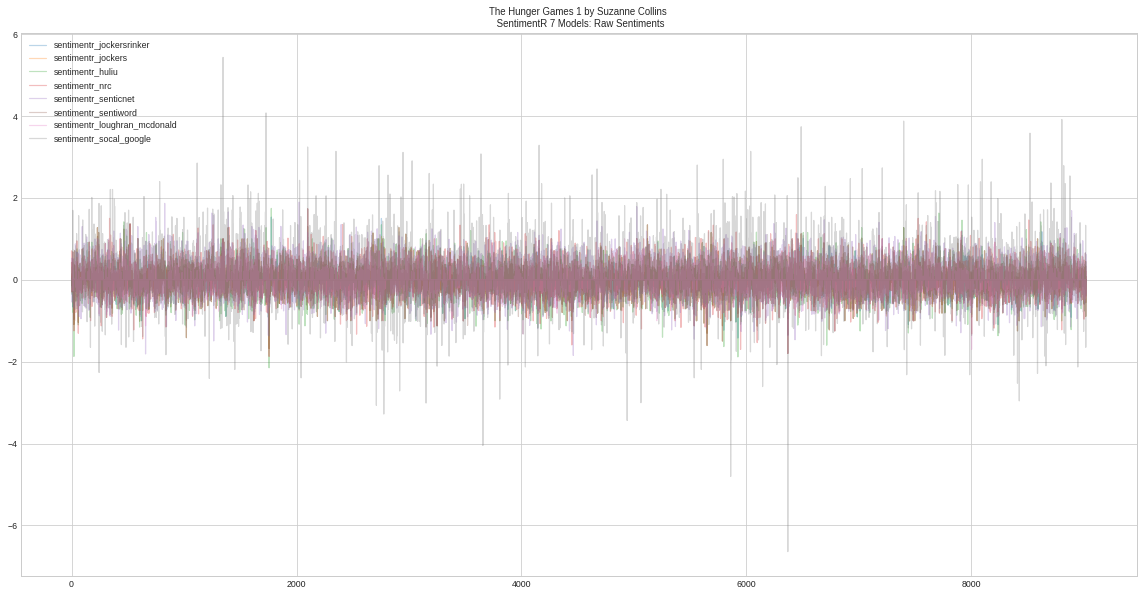

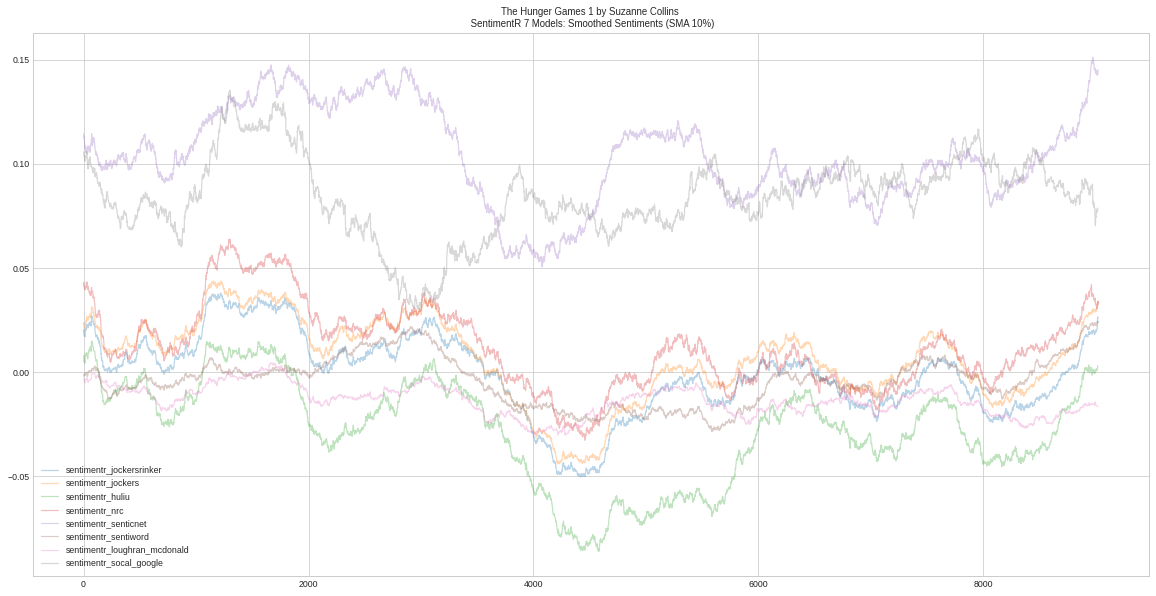

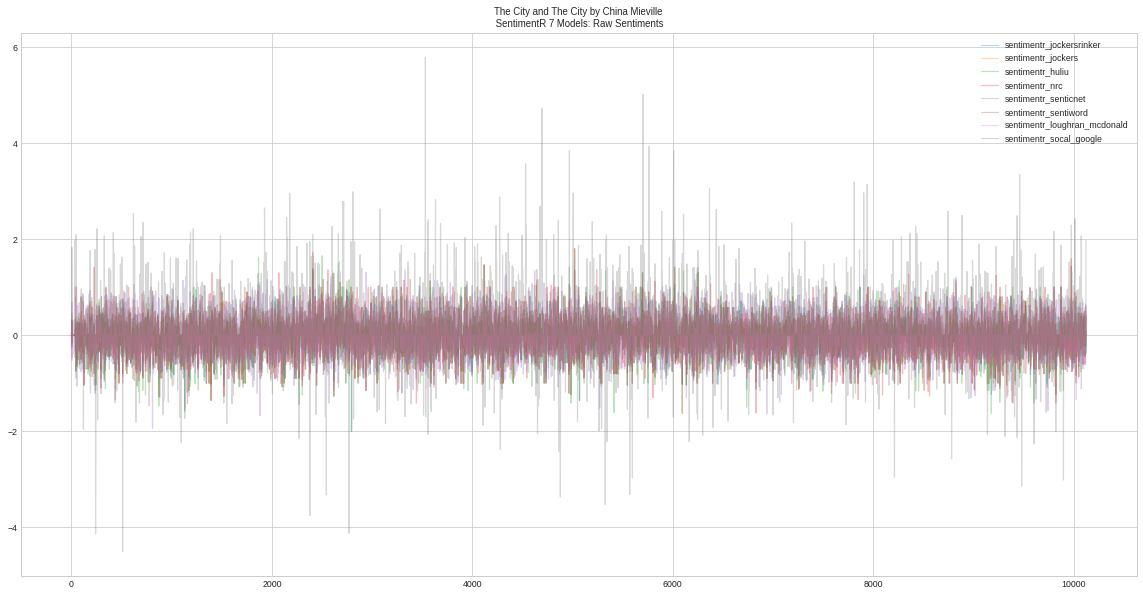

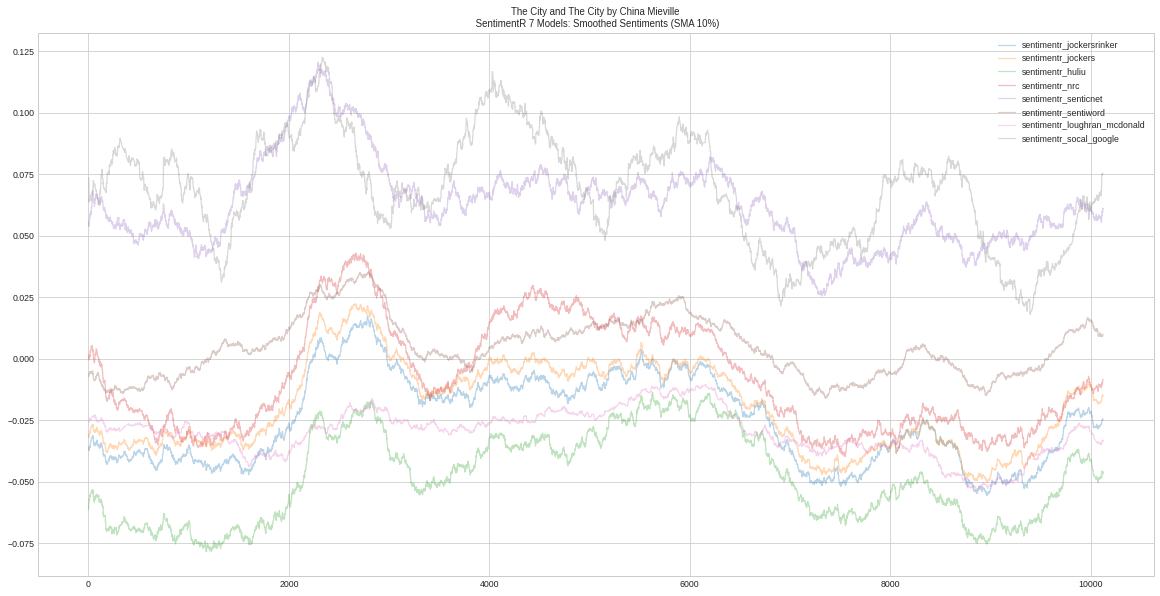

In [ ]:
# Verify 7 SentimentR Models with Plots

for i, anovel in enumerate(list(corpus_texts_dt.keys())):

  print(f'Novel #{i}: {corpus_titles_dt[anovel][0]}')

  # Raw Sentiments 
  fig = corpus_texts_dt[anovel][cols_sentimentr_ls].plot(title=f'{corpus_titles_dt[anovel][0]}\n SentimentR 7 Models: Raw Sentiments', alpha=0.3)
  # plt.show();

  if Save_Raw_Plots:
    save_filename = f'{SUBDIR_PLOTS}plot_sentimentr_raw_{anovel}_dpi{Resolution}.png'
    print(f'\n\nSaving to: {save_filename}')
    plt.savefig(save_filename, dpi=int(Resolution))

  
  # Smoothed Sentiments (SMA 10%)
  # novel_sample = 'cdickens_achristmascarol'
  win_10per = int(corpus_texts_dt[anovel].shape[0] * 0.1)
  corpus_texts_dt[anovel][cols_sentimentr_ls].rolling(win_10per, center=True, min_periods=0).mean().plot(title=f'{corpus_titles_dt[anovel][0]}\n SentimentR 7 Models: Smoothed Sentiments (SMA 10%)', alpha=0.3)
  # plt.show();

  if Save_Smooth_Plots:
    save_filename = f'{SUBDIR_PLOTS}plot_sentimentr_smooth10sma_{anovel}_dpi{Resolution}.png'
    print(f'\n\nSaving to: {save_filename}')
    plt.savefig(save_filename, dpi=int(Resolution))


# **END OF NOTEBOOK**

---